<a href="https://colab.research.google.com/github/Ryu0506/biometric-security/blob/main/fingerprint_recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 내 드라이브 연동
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


###라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import random

## 데이터 전처리

### Data Augmentation

In [ ]:
def augmen(file_names, directory_path, num):
  j = 10
  for file_name in file_names:
    file_path = '{}/{}'.format(directory_path, file_name)
    image = Image.open(file_path).convert('L')
    image = np.array(image)
    augs = [image]*150

    seq = iaa.Sequential([
      iaa.GaussianBlur(sigma=(0,0.5)),
      iaa.Affine(
          scale={"x":(0.9, 1.1), "y":(0.9,1.1)},
          translate_percent = {"x":(-0.1, 0.1), "y":(-0.1,0.1)},
          rotate=(-30,30),
          order=[0,1],
          cval=255
      )
    ], random_order = True)

    augs = seq.augment_images(augs)

    for aug in augs:
      j+=1
      img = Image.fromarray(aug)
      path = '{}/{}'.format(directory_path, str(num) + ' (' + str(j) + ').bmp')
      img.save(path)

In [ ]:
# Data Augmentation

path = "/gdrive/My Drive/01_finger_training"
for i in range(1,9):
  directory_path = '{}/{}'.format(path, i)
  file_names = os.listdir(directory_path)
  augmen(file_names, directory_path, i)

### Data read

In [ ]:
def data_load(data_dir, width=144, height=144):
    x_data = []
    y_data = []
    folder_names=['1','2','3', '4', '5', '6', '7', '8']

    for folder_name in folder_names:
        file_names = os.listdir('{}/{}'.format(data_dir, folder_name))
        for file_name in file_names:
            file_path = '{}/{}/{}'.format(data_dir, folder_name, file_name)
            image = Image.open(file_path).convert('L')
            image = image.resize((width, height))
            numpy_image = np.array(image) #이미지 타입을 넘파이 타입으로 변환
            x_data.append(numpy_image/255.)
            y_data.append(int(folder_name)-1)
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data

In [ ]:
x_data, y_data = data_load('/gdrive/My Drive/01_finger_training')

labels = ['1', '2','3','4','5','6','7','8']

### Data 확인

In [ ]:
print(x_data.shape)

(12080, 144, 144)


(12080, 144, 144, 1) (12080,)


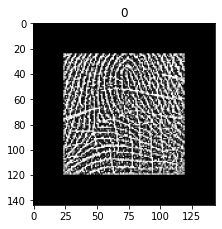

In [ ]:
x_data = x_data.reshape((12080, 144, 144, 1)) # Data에 channel을 추가해준다. (1: 흑백)
print(x_data.shape, y_data.shape)

# 이미지 확인
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_data[0])
plt.imshow(x_data[0].squeeze(), cmap='gray')

## Model 설계

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras import regularizers

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(144, 144, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 144, 144, 32)      320       
_________________________________________________________________
batch_normalization_30 (Batc (None, 144, 144, 32)      128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 35, 35, 32)      

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras import regularizers

def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(144, 144, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(l=0.01), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
  ])

  model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics = ['acc'])
  
  return model

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#조기종료
earlystop=EarlyStopping(patience=5)

#학습률 조정
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',
                                          patience=2,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)
#callback 설정
callback=[earlystop,learning_rate_reduction]

In [ ]:
# CrossValidation 적용

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=1)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

idx = 0
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

for train_index, test_index in kf.split(x_data, y_data):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    model = create_model()

    # model train
    history = model.fit(x_train, y_train,
                    validation_split = 0.1,
                    epochs = 50,
                    batch_size = 32,
                    verbose=1,
                    callbacks = callback
                    )
    
    model.save('/gdrive/My Drive/' + 'fingerprint_' + str(idx) + '.h5')
    idx += 1

    # model 예측
    predictions = model.predict(x_test)

    y_pred = []
    for i in range(len(predictions)):
      p = np.argmax(predictions[i])
      y_pred.append(p)
    y_pred = np.array(y_pred)
    
    accuracy = accuracy_score(y_test, y_pred)
    all_accuracy.append(accuracy)

    precision = precision_score(y_test, y_pred, average = 'macro')
    all_precision.append(precision)

    recall = recall_score(y_test, y_pred, average = 'macro')
    all_recall.append(recall)

    f1 = f1_score(y_test, y_pred, average = 'macro')
    all_f1.append(f1)

Epoch 1/50
272/272 [==============================] - 7s 24ms/step - loss: 3.2423 - acc: 0.3767 - val_loss: 3.7840 - val_acc: 0.0000e+00
Epoch 2/50
272/272 [==============================] - 6s 23ms/step - loss: 0.6447 - acc: 0.9394 - val_loss: 0.5718 - val_acc: 0.8800
Epoch 3/50
272/272 [==============================] - 6s 23ms/step - loss: 0.2805 - acc: 0.9687 - val_loss: 0.2273 - val_acc: 0.9752
Epoch 4/50
272/272 [==============================] - 6s 23ms/step - loss: 0.2106 - acc: 0.9680 - val_loss: 0.1880 - val_acc: 0.9648
Epoch 5/50
272/272 [==============================] - 6s 23ms/step - loss: 0.1212 - acc: 0.9859 - val_loss: 0.0757 - val_acc: 0.9990
Epoch 6/50
272/272 [==============================] - 6s 23ms/step - loss: 0.0885 - acc: 0.9908 - val_loss: 0.1814 - val_acc: 0.9504
Epoch 7/50
272/272 [==============================] - 6s 23ms/step - loss: 0.0924 - acc: 0.9873 - val_loss: 1.3100 - val_acc: 0.6494

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00050

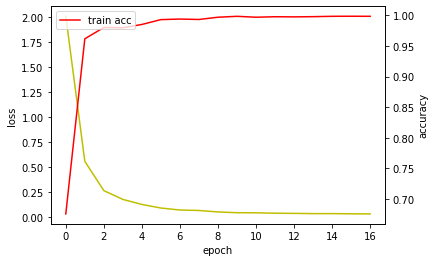

In [ ]:
# train accuracy, loss

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax.plot(history.history['acc'], 'r', label='train acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

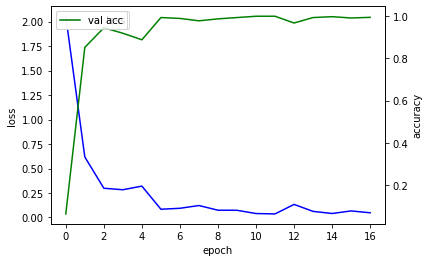

In [ ]:
# validation accuracy, loss

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['val_loss'], 'b', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
for i in range(len(all_accuracy)):
  print('model ' + str(i+1))
  print()
  print('accuracy : %.4f, precision : %.4f, recall : %.4f, f1 : %.4f' % (all_accuracy[i], all_precision[i], all_recall[i], all_f1[i])) 
  print('-------------------------------------------------------------------------')

model 1

accuracy : 1.0000, precision : 1.0000, recall : 1.0000, f1 : 1.0000
-------------------------------------------------------------------------
model 2

accuracy : 1.0000, precision : 1.0000, recall : 1.0000, f1 : 1.0000
-------------------------------------------------------------------------
model 3

accuracy : 1.0000, precision : 1.0000, recall : 1.0000, f1 : 1.0000
-------------------------------------------------------------------------
model 4

accuracy : 1.0000, precision : 1.0000, recall : 1.0000, f1 : 1.0000
-------------------------------------------------------------------------
model 5

accuracy : 0.9996, precision : 0.9996, recall : 0.9996, f1 : 0.9996
-------------------------------------------------------------------------


## Test Dataset 예측

In [ ]:
loaded = keras.models.load_model("/gdrive/My Drive/fingerprint_4.h5")
test_path = '/gdrive/My Drive/01_finger_test'
test_file = []
x_test_data = []
width = 144
height = 144

for i in range(1,81):
  test_file.append(str(i)+'.bmp')

for file_name in test_file:
    file_path = '{}/{}'.format(test_path, file_name)
    image = Image.open(file_path).convert('L')
    image = image.resize((width, height))
    numpy_image = np.array(image) #이미지 타입을 넘파이 타입으로 변환
    x_test_data.append(numpy_image/255.)

x_test_data = np.array(x_test_data)
x_test_data = x_test_data.reshape((80, 144, 144, 1))

predictions = loaded.predict(x_test_data)

y_pred = []

for i in range(len(predictions)):
  p = np.argmax(predictions[i])
  y_pred.append(p+1)

In [ ]:
import pandas as pd

plist = []
print(y_pred)
for i in range(1,81):
  plist.append(i)

columns = ["Image", "Answer"]
pred_df = pd.DataFrame([x for x in zip(plist, y_pred)], columns=columns)
pred_df

[7, 1, 2, 6, 1, 2, 5, 6, 5, 3, 6, 2, 5, 2, 1, 6, 8, 5, 7, 3, 6, 1, 2, 8, 8, 7, 8, 5, 8, 5, 8, 1, 5, 2, 4, 7, 1, 3, 4, 6, 7, 4, 7, 6, 8, 2, 3, 3, 5, 8, 4, 4, 4, 4, 3, 2, 2, 5, 5, 8, 1, 1, 4, 7, 6, 3, 7, 3, 7, 4, 6, 3, 3, 6, 2, 1, 8, 1, 7, 4]


,Image,Answer
0,1,7
1,2,1
2,3,2
3,4,6
4,5,1
...,...,...
75,76,1
76,77,8
77,78,1
78,79,7
